In [1]:
# global packages
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os import path
import sys
sys.path.append('../')

assert tf.__version__>='1.0.0', ('You should use Tensorflow 1.0 or superior')

In [2]:
#net_path = '../pretrained/xc_conv5_32c_s4_e40.mat'
net_path = '../pretrained/baseline-conv5_e55.mat'
root_path = '/home/berti/ILSVRC2015_crops_90/Data/VID/train'
video_path = 'b/ILSVRC2015_train_00033007'
crop_x = '000050.00.crop.x.jpg'
crop_z = '000000.00.crop.z.jpg'
im_x = np.expand_dims(plt.imread(path.join(root_path, video_path, crop_x)), 0)
im_z = np.expand_dims(plt.imread(path.join(root_path, video_path, crop_z)), 0)
pyramid_x = np.concatenate((im_x,im_x,im_x),axis=0)
pyramid_z = np.concatenate((im_z,im_z,im_z),axis=0)

In [3]:
from src.siamese import import_siamese
X = tf.placeholder(tf.float32)
Z = tf.placeholder(tf.float32)
net = import_siamese(net_path, X, Z)

> Layer 1
		CONV: setting br_conv1f br_conv1b
		CONV: stride 2, filter-group False
		BNORM: setting br_bn1b br_bn1m br_bn1x
		MAX-POOL: size 3 and stride 2
> Layer 2
		CONV: setting br_conv2f br_conv2b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn2b br_bn2m br_bn2x
		MAX-POOL: size 3 and stride 1
> Layer 3
		CONV: setting br_conv3f br_conv3b
		CONV: stride 1, filter-group False
		BNORM: setting br_bn3b br_bn3m br_bn3x
> Layer 4
		CONV: setting br_conv4f br_conv4b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn4b br_bn4m br_bn4x
> Layer 5
		CONV: setting br_conv5f br_conv5b
		CONV: stride 1, filter-group True


In [4]:
# evaluate the network
with tf.Session() as sess:
    test_writer = tf.summary.FileWriter('./logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    out = sess.run(net, feed_dict={X:pyramid_x, Z:pyramid_z})
#     out_z, out_x = sess.run([net_z, net_x], feed_dict={X:pyramid_x, Z:pyramid_z})

(3, 33, 33, 1)
-3.66959
3.38425
-7.06083


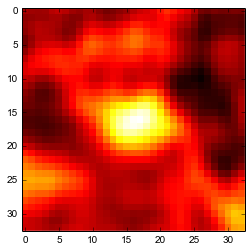

In [5]:
# check the output
print out.shape
print np.mean(out)
print np.max(out)
print np.min(out)
plt.imshow(out[2, :, :, 0], interpolation='none', cmap='hot')